In [1]:
import numpy as np 
import sys 
import matplotlib.pyplot as plt
import time
import scipy.stats as st
import scipy.cluster.vq as cvq
import multiprocessing as mp
import image_tools as it
from scipy.ndimage import imread


import numpy.ma as ma
import scipy.stats as st
import scipy.signal as si
from astropy.io import fits
from astropy.table import Table
import scipy.ndimage.morphology as morph
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
%reload_ext autoreload

import parameters
import gibbs_sampler as gs
import fields_tools as ft
import seg_OTMF as sot


In [2]:
sys.path.insert(0,'./libext/MPDAF')
import mpdaf

from mpdaf.obj import WCS
from mpdaf.obj import WaveCoord
from mpdaf.obj import Image
from mpdaf.obj import Spectrum
from mpdaf.obj import Cube


from mpdaf.sdetect import Source, SourceList
from mpdaf.sdetect import Catalog

In [3]:
# Version information
version = 0.1
# source dir
nom_dossier='./data/Lien vers lya_udf10/'

In [4]:


cat = Catalog.read('./data/udf10_c031_e026_withz.vot')


/home/miv/courbot/anaconda/lib/python2.7/site-packages/astropy/table/column.py:1095: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


In [5]:
cube = Cube('./data/DATACUBE_UDF-10.fits')

#cat_fits = fits.open('./data/Catalog_HDFS_v1p0.fits',memmap=True)

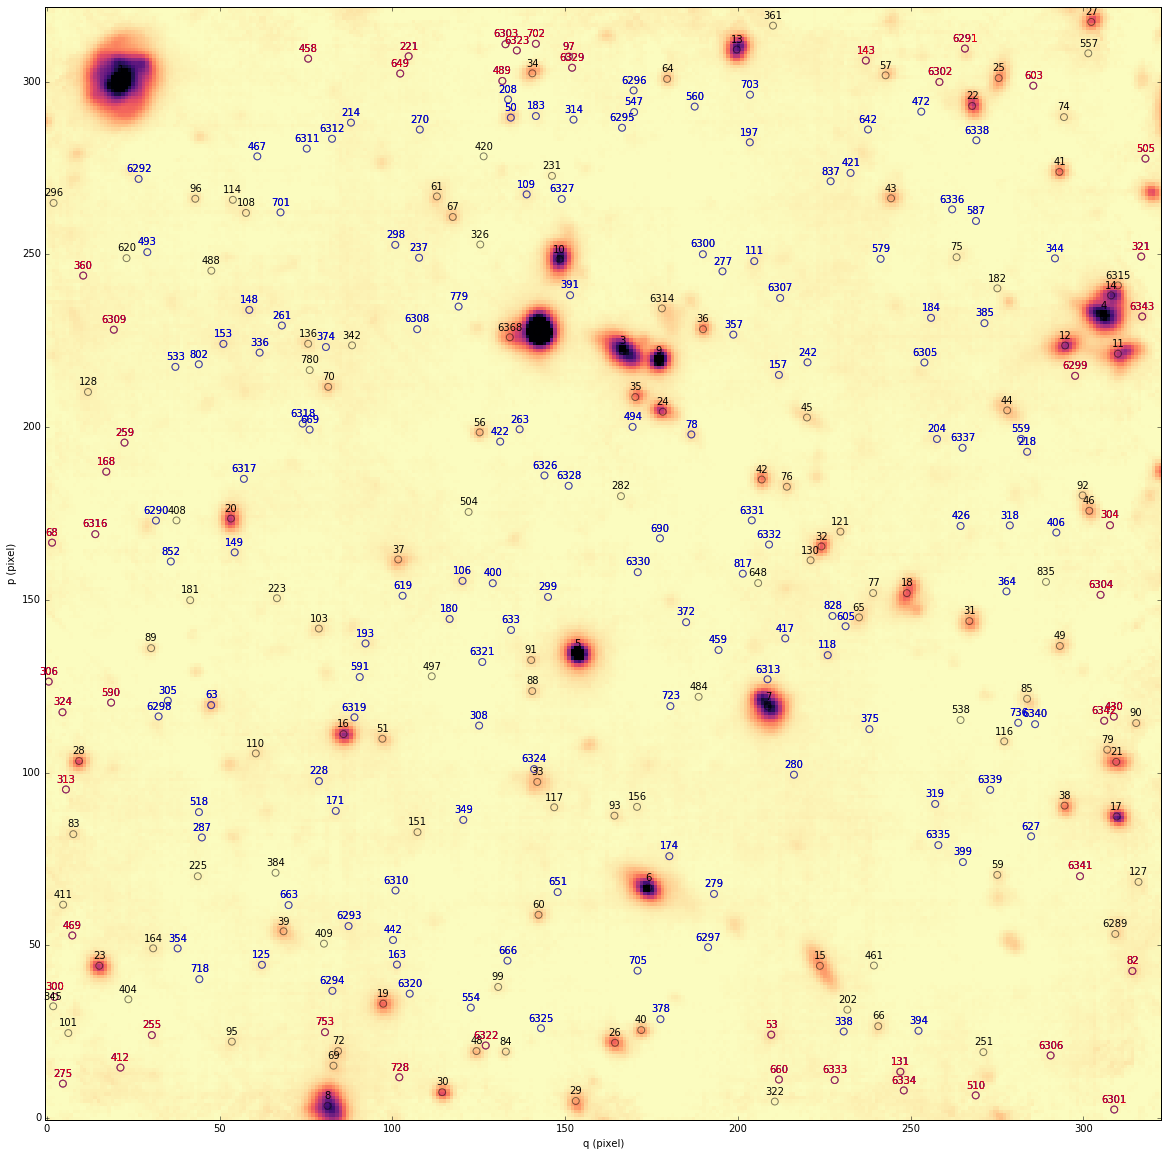

In [6]:
cat_lya=cat[cat['TYPE']==6]

im = cube.mean(axis=0)
id_nobor = np.abs(cat_lya.edgedist(wcs=im.wcs))>25*0.2
fig = plt.figure(figsize=(20,20))
ax = plt.subplot(1,1,1)

im.plot(vmin=0,vmax=5,cmap='magma_r')
cat.plot_id(ax,im.wcs)
cat_lya.plot_id(ax,im.wcs,col='blue')

cat_lya[id_nobor==0].plot_id(ax,im.wcs,col='red')




In [7]:
lambda_0 = 4750    # see Bacon et al, 2015
lambda_lya = 1216
pas_spectral = 1.25 # Angstrom / spectral band




#liste_obj=(11724,149,153,180,184,204,214,252,364,400,547,559,579,675,797)
liste_obj = (78,149,153,157,183,208,214,237,547,619,802,828,6311,6312,6290,6295)
liste_obj_lya=cat_lya['ID']
liste_obj_lya_nobor = cat_lya[id_nobor]['ID']
liste_obj_bor = cat_lya[id_nobor==0]['ID']

In [7]:
listeciel = (308,354,560,587,666,837,852,6294,6312,6313,6317,6319,6324,6326)
listeechec=(193,  227,  228,  287 , 349 , 394 , 406 , 421,  493,  518 , 533 , 663 , 690 , 705,  779,
  817, 6300 ,6305 ,6318, 6328, 6331, 6332 ,6338 )

#taille80 = (242,321,412,467,590,591,669,736,802,6295,6300,6308,6311,6333, 6342)
ok = (63,78,82,109,143,148,149,163,183,204,208,214,218,237,261, 275,298,306,324,344,360,378,391,399,400,494,510,559,590,619,642,660,703,828, 6290,6293,6297,6298,6299,6303,6304,6316,6323,6327,6340,6342)

taille40 = (263,385,605,703,6325)

taille50 = (263,308,385,469,579,605,619,702,703,6319,6324,6325,305)

taille100 = (111,153,277,314,357,442,718,6294,6335,255,6311,579)

taille70 = (106,430,642,118,279,313,318,374,489,633,723,6291,6313,)

taille80 = (50,97,6329,)

taille90=()

taille35 = (6318,6341)



lambda_coupe_droite_5 = (171,255,426,505,6334,627,705,6305)
lambda_plus_7 = (417,852,6321)
lambda_coupe_droite_gauche_5 = (336,) 
lambda_plus_large = (50,97,6329,)


taille80 = (171,426,627)
taille50=(6318,6341,279,718,255,)
taille100=(106,633,308)
taille40=(318,374,6334,417)
taille120 = (153,111,277,314,6294,6311)

liste_a_proc = (308,)#+taille100+taille80+taille40+taille50#lambda_coupe_droite_5+lambda_plus_7+lambda_plus_large+lambda_coupe_droite_gauche_5#taille35+taille40+taille70+taille100#+taille100+taille70

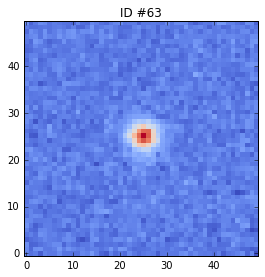

In [8]:
from astropy.table import Table
i = 0
nb_li=20
W = 20*1.25
plt.figure(figsize=(3*5,nb_li*5))
for num_obj in (63,):#liste_a_proc:#(168,304,321,412,505,510,603,6301,6306,6322,6333,6334,6341,6343,300):#(208,):

    # Ici : modifier les largeurs S des sous-cubes
    
    
    num_cat = np.where(cat['ID']==num_obj)[0][0]
    ligne_cat = cat[num_cat]
    
    listebord_large = (82,97,131,255,430,469,702,6302,6304,6306,6329,6334)
    #
    #if num_obj in (666,459,270,349,406,493,6330,6320,394,6313,533,560,642,149,828,50,357,642,6325,6327,6338,  261,6335,6319,  703,779,338, 6311,214,579,385,6317,718,6294,442,6313,6324, 263,171,605,627,280,705):
    #    S = 80
    #elif num_obj in listebord_large or num_obj in taille80 :
    #    S = 80
    #elif num_obj in (6295,237,183,619,  6335,701,354):
    #    S = 60
    #elif num_obj in (153,78,208,494,308,779,627,385) or num_obj in taille100:
    #    S=100
    #elif num_obj in (157,208):
    #    S=120
    if num_obj in taille50:
        S=50
    elif num_obj in taille35:
        S=35
            
    elif num_obj in taille100:
        S = 100
    elif num_obj in taille80:
        S=80          
    elif num_obj in taille70:
        S=70    
    elif num_obj in taille40:
        S=40   
        
    elif num_obj in taille120:
        S = 120   
    else:
        S = 50
     
    


    
    lbda_reel = (1+ligne_cat['Z_MUSE'])*1216
    if num_obj==208:
        W = 40.*1.25
    elif num_obj in (547,6295,) :
        W = 12*1.25

    elif num_obj in (6311,6312,802):
        W = 6*1.25
    elif num_obj==802:
        W = 6.*1.25
    else:
        W = 20*1.25
            
    # decalage vers la gauche en wave        
    if num_obj==802:
        deb = lbda_reel-W/2.-3.5*1.25
        fin = lbda_reel+W/2.-3.5*1.25
    elif num_obj in (6311,174,197,319,399,417, 690,701,817,852,690,701,817,852,6325,6317,627, 168,412,) :
        deb = lbda_reel-W/2.-5*1.25
        fin = lbd,=a_reel+W/2.-5*1.25
        
    elif num_obj in (372,426,587,852,666, 6306,6322,6333) :
        deb = lbda_reel-W/2.-10*1.25
        fin = lbda_reel+W/2.-10*1.25 
    elif num_obj==518:
        deb = lbda_reel-W/2.-20*1.25
        fin = lbda_reel+W/2.-20*1.25 
        
    # decalage vers la droite en wavelength
    elif num_obj==6312:
        deb = lbda_reel-W/2.+2*1.25
        fin = lbda_reel+W/2.+2*1.25     
      
    elif num_obj in (125,171,184,228,270, 718,6293,6326,6328, 505,510):
        deb = lbda_reel-W/2.+5*1.25
        fin = lbda_reel+W/2.+5*1.25
        
    elif num_obj in (375,  304,321,603,6301,6341,300) :
        deb = lbda_reel-W/2.+10*1.25
        fin = lbda_reel+W/2.+10*1.25       
        
    # couper des parties
    # la gauche
    elif num_obj in (280,338,417) :
        deb = lbda_reel-W/2.+10*1.25
        fin = lbda_reel+W/2. 
    elif num_obj==837:
        deb = lbda_reel-W/2.+5*1.25
        fin = lbda_reel+W/2. 
    #la droite    
    elif num_obj in (579,651,171,6319,6335):
        deb = lbda_reel-W/2.
        fin = lbda_reel+W/2.-10*1.25
    #les deux
    elif num_obj in (6313,6324, 6343):
        deb = lbda_reel-W/2.+5*1.25
        fin = lbda_reel+W/2.-5*1.25          
    # par defaut    
    else: 
        deb = lbda_reel-W/2.
        fin = lbda_reel+W/2.
        
    if num_obj in lambda_coupe_droite_5:
        fin -= 5*1.25
    elif num_obj in lambda_coupe_droite_gauche_5:
        deb +=5*1.25
        fin -= 5*1.25
    elif num_obj in lambda_plus_7:
        deb +=7*1.25
        fin += 7*1.25
    elif num_obj in lambda_plus_large:
        deb -= W/2
        fin += W/2
    
    sub_cube_tight = cube.subcube((ligne_cat['DEC'],ligne_cat['RA']),S*0.2,lbda=(deb,fin))#,unit_wave='pixel')
    
    sub_cube_large = cube.subcube((ligne_cat['DEC'],ligne_cat['RA']),S*0.2,lbda=(deb-50,fin+50))
    im_med = sub_cube_large.median(axis=0)
    
    sct_ms = sub_cube_tight.data.data - im_med.data.data[np.newaxis,:,:]
    sub_cube_tight_ms = Cube.new_from_obj(sub_cube_tight,data=sct_ms)
    
    #if num_obj in (270,349,406,385,493,459,666,  208,157,50,642,6325,6338, 703,779,338, 214,6294,385,627, 394,6313,533,560,642,280,705,6330,6320): #153,619,828
    #    lmin,lmax = sub_cube_tight.get_range()[0],sub_cube_tight.get_range()[3]
    #    if num_obj==208:
    #        xmin = 20. ;        xmax = 120.
    #        ymin = 10 ;        ymax = 75.
    #
    #    elif num_obj==157:
    #        xmin = 20. ;        xmax = 100.
    #        ymin = 30. ;        ymax = 110.
    #        
    #    elif num_obj==50:
    #        xmin = 0. ;        xmax = 80.
    #        ymin = 10 ;        ymax = 70.
    #    elif num_obj==642:
    #        xmin = 0. ;        xmax = 80.
    #        ymin = 0 ;        ymax = 70.
    #    elif num_obj==6325:
    #        xmin = 0. ;        xmax = 80.
    #        ymin = 22 ;        ymax = 80.
    #    elif num_obj==6338:
    #        xmin = 20. ;        xmax = 80.
    #        ymin = 20 ;        ymax = 70.            
    #    elif num_obj==703:
    #        xmin = 0. ;        xmax = 80.
    #        ymin = 0 ;        ymax = 55.    
    #    elif num_obj==779:
    #        xmin = 0. ;        xmax = 50.
    #        ymin = 15 ;        ymax = 65.    
    #    elif num_obj==338:
    #        xmin = 10. ;        xmax = 70.
    #        ymin = 30. ;        ymax = 80.
    #    elif num_obj==214:
    #        xmin = 0. ;        xmax = 80.
    #        ymin = 0 ;        ymax = 60.
    #        
    #    elif num_obj==6294:
    #        xmin = 0. ;        xmax = 80.
    #        ymin = 20 ;        ymax = 80.
    #    elif num_obj==385:
    #        xmin = 10. ;        xmax = 80.
    #        ymin = 10 ;        ymax = 80.   
    #    elif num_obj==627:
    #        xmin = 00. ;        xmax = 70.
    #        ymin = 0 ;        ymax = 80.        
    #    elif num_obj in (394,6313,533,642,6330,6320): # haut
    #        xmin = 15 ; xmax = 65
    #        ymin = 25; ymax =  75
    #        
    #    elif num_obj in (560,280,705): # bas
    #        xmin = 15; xmax = 65
    #        ymin = 5; ymax = 55
    #        
    #    elif num_obj in (349,406,): # gauche
    #        xmin = 5; xmax = 55
    #        ymin = 15; ymax = 65
    #    elif num_obj in (459,): # gauche ++
    #        xmin = 0; xmax = 50
    #        ymin = 15; ymax = 65            
    #    elif num_obj in (493,): # droite
    #        xmin = 25; xmax = 75
    #        ymin = 15; ymax = 65    
    #    elif num_obj in (666,): # droite
    #        xmin = 15 ; xmax = 65
    #        ymin = 20; ymax =  60          
    #    elif num_obj in (270,): # bas  gauche
    #        xmin = 5; xmax = 55
    #        ymin = 5; ymax = 55
    #        
    #        
    #    coord = [lmin,ymin,xmin,lmax,ymax,xmax]
    #    sub_cube_tight = sub_cube_tight.truncate(coord,unit_wcs=None)
    #    sub_cube_tight_ms = sub_cube_tight_ms.truncate(coord,unit_wcs=None)

    
    sub_cube_tight_ms.mask = sub_cube_tight.data.mask
    dumb, dumb2 = sub_cube_tight.crop(), sub_cube_tight_ms.crop()
    
    ax = plt.subplot(nb_li,3,i+1)
    im = sub_cube_tight_ms.sum(axis=0)
    im_np = im.data
    plt.imshow(im_np,origin='lower',cmap=plt.cm.coolwarm,interpolation='nearest')
    #im.plot(plt.cm.coolwarm)
    plt.title('ID #'+str(ligne_cat['ID']))
    #ax.set
    i+=1
    
    
    tabz = Table() ; cubes = {};
    tabz['z'] = [ligne_cat['Z_MUSE']]
    cubes['cube'] = sub_cube_tight
    cubes['cube_ms'] = sub_cube_tight_ms
    cubes['cube_large']=sub_cube_large

    src = Source.from_data(ID=ligne_cat['ID'],
                          ra = ligne_cat['RA'],
                          dec = ligne_cat['DEC'],
                          origin = ('lyama','0.1','DATACUBE_UDF-10.fits'),
                           z=tabz,
                           cubes=cubes,
                           mask_invalid=False
                           )
    src.write('./data/udf10_lya_sources_v0/udf10_63test.fits')
    
    

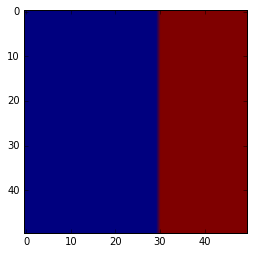

In [26]:
im0 = sub_cube_tight.mean(axis=0)

sub_cube_tight_ms.mask = sub_cube_tight.data.mask
im = sub_cube_tight_ms.mean(axis=0)
plt.imshow(im.mask)

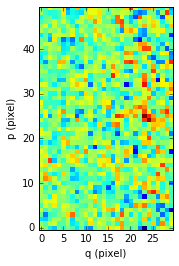

In [28]:
a=sub_cube_tight_ms.crop()
sub_cube_tight_ms.mean(axis=0).plot()


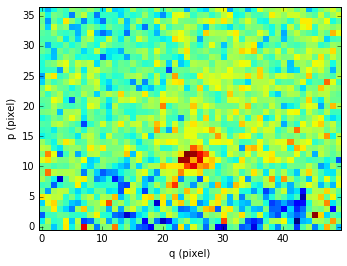

In [18]:
dumb = sub_cube_tight.crop()
sub_cube_tight.mean(axis=(0)).plot()
#print a

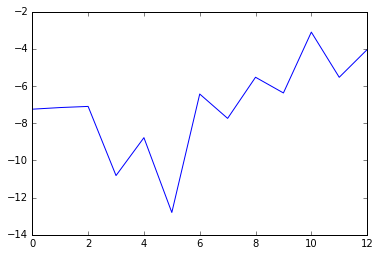

In [57]:
# quelques calsuls sur les res

inten = np.array([0.25,0.25,0.25,0.15,0.25,0.15,0.25,0.15,0.25,0.2,0.5,0.35,0.25])
sigs = np.array([0.5758,0.5700,0.5660,0.5210,0.6868,0.6548,0.5242,0.3657,0.4725,0.4166,0.7147,0.6617,0.3982])
plt.plot(20*np.log10(inten/sigs))

/home/miv/courbot/anaconda/lib/python2.7/site-packages/astropy/stats/lombscargle/implementations/main.py:21: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .cython_impl import lombscargle_cython
/home/miv/courbot/anaconda/lib/python2.7/site-packages/astropy/stats/lombscargle/implementations/main.py:21: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  from .cython_impl import lombscargle_cython


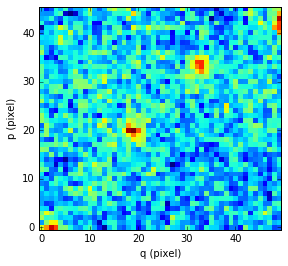

In [9]:
#import astropy.units as Unit

lmin = sub_cube_tight.get_range()[0]
lmax = sub_cube_tight.get_range()[3]

xmin = 10.
xmax = 80

ymin = 10
ymax = 55.

coord = [lmin,ymin,xmin,lmax,ymax,xmax]

scts = sub_cube_tight.truncate(coord,unit_wcs=None)#,mask=False)
scts.sum(axis=0).plot()

In [10]:
scts